# 0.0 IMPORTS

In [1]:
import numpy as np
import pandas as pd
import inflection
import math
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from IPython.core.display import HTML
from IPython.display import Image

%matplotlib inline

## 0.1 Helpers Functions

## 0.2 Loading Data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory= False)
df_store_raw = pd.read_csv('data/store.csv', low_memory= False)

# merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 DATA DESCRIPTION

In [3]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [4]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# Rename
df1.columns = cols_new

## 1.2 Data Dimentions

In [5]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 Data Types

In [6]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [8]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else (x))

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply ( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis =1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis =1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply ( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis =1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis =1)



In [9]:
# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 
                                                             else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

## 1.6 Change Types

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [11]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [13]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - Std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance'>

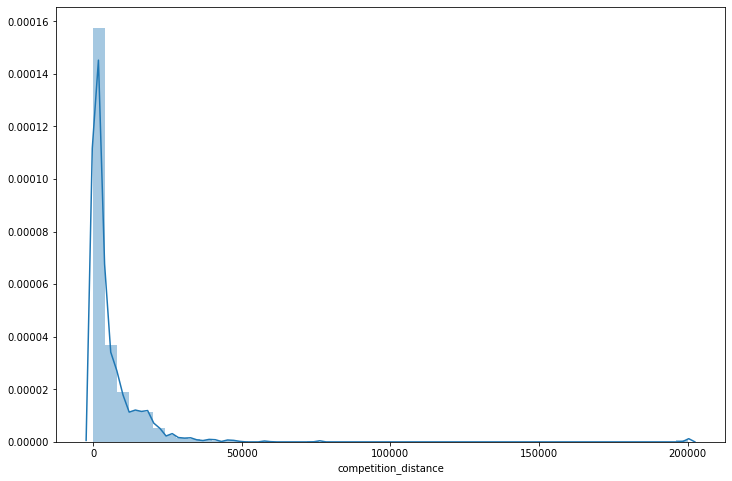

In [14]:
plt.figure(figsize = (12, 8))
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [15]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

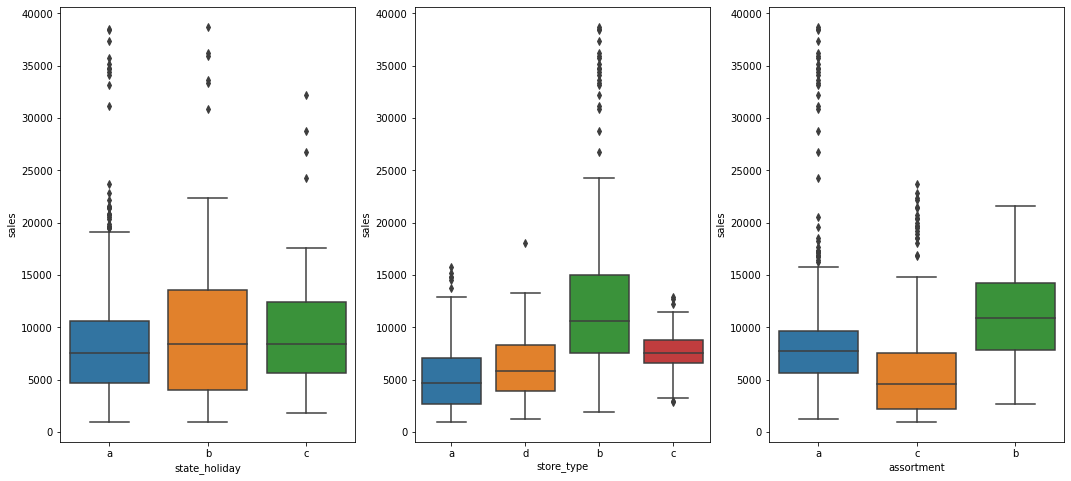

In [16]:
plt.figure(figsize = (18, 8))
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1, )

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1, )

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1, )

# 2.0 FEATURE ENGENEERING

In [17]:
df2 = df1.copy()

## 2.1 Mind Map Hypotheses

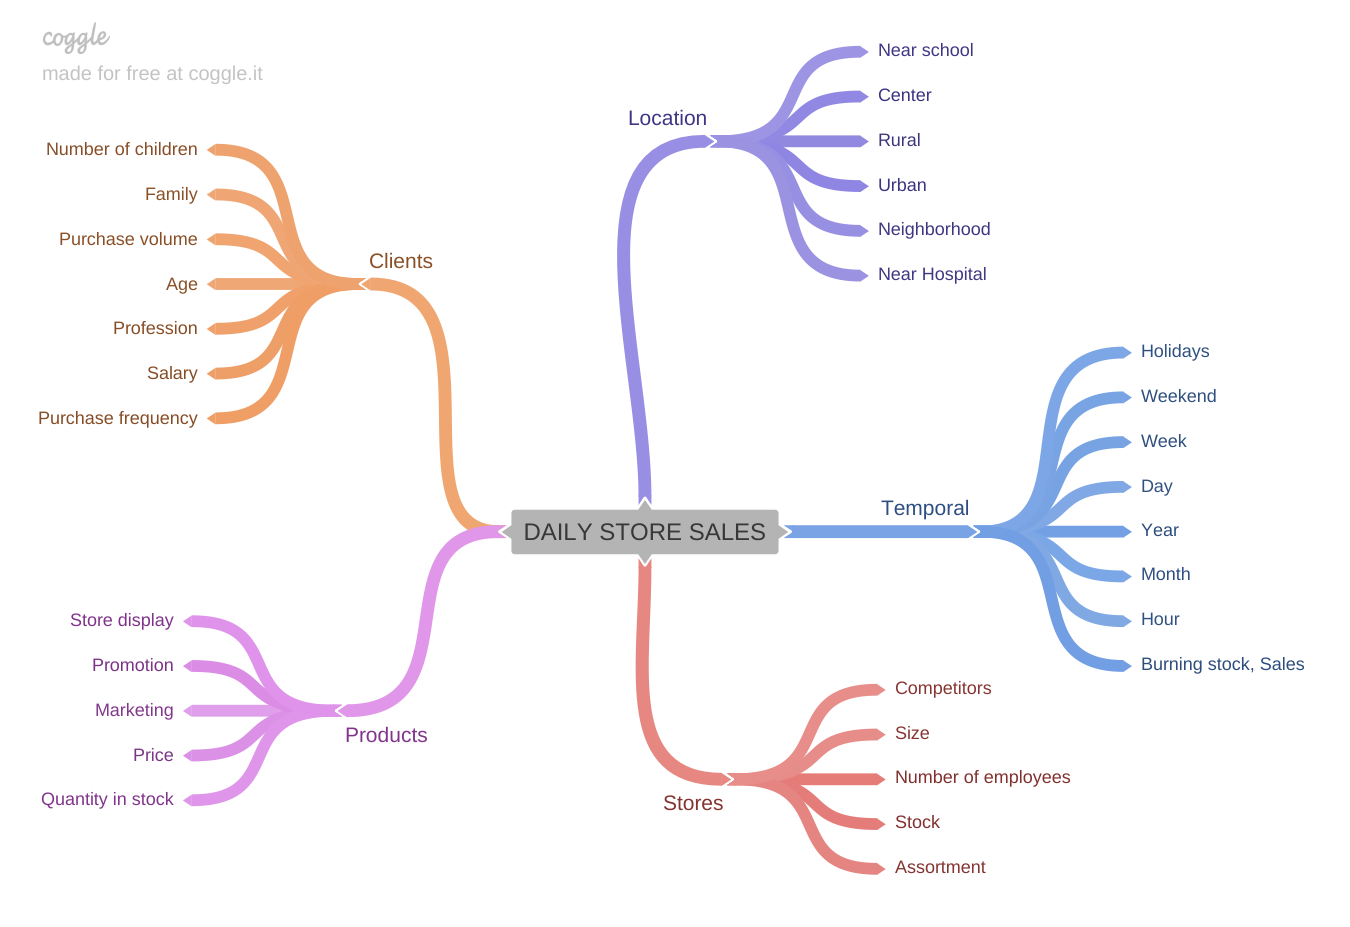

In [18]:
Image ('img/mindmaps.png')

## 2.2 Hypotheses criation

### 2.2.1 Hypotheses Stores

**1.** Stores with more employees should have more sales.

**2.** Stores with more products in stock should have more sales.

**3.** Stores with more assortment should  have more sales.

**4.** Stores with bigger size should  have more sales.

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer competitors should sell more.

**7.** Stores with home delivery should sell more.

### 2.2.2 Hypotheses Clients

**1.** Stores with customers with the largest number of children should have more sales.

**2.** Stores with customers with family should have more sales.

**3.** Stores with older customers should sell more.

**4.** Stores with customers with high-paying jobs should sell more.

**5.** Stores with high purchase frequency per client should sell more.

**6.** Stores ith high purchase volume per client should sell more.

**7.** Stores with more clients should sell more.

### 2.2.3 Hypotheses Products

**1.** Stores with more investment in marketing should have more sales.

**2.** Stores that show more products in showcases should sell more.

**3.** Stores with lower prices should have more sales.

**4.** Higher discount stores should sell more.

**5.** Stores that carry out extended promotions should sell more.

**6.** Stores with large stock should have more sales.

**7.** Stores with more days of promotions should sell more.

**8.** Stores with more consecutive promotions should sell more.

### 2.2.4 Hypotheses Temporal

**1.** Stores open during the Christmas holiday should sell more.

**2.** Older stores should sell more.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more before the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

**7.** Stores that works 24 hours should sell more.

### 2.2.5 Hypotheses Location

**1.** Stores in urban areas should sell more.

**2.** Stores in city centers should sell more.

**3.** Stores in rural areas should sell less.

**4.** Residential neighborhood stores should sell more.

**5.** Stores near schools should sell more.

**6.** Stores near hospitals should sell more.

## 2.3 Hypotheses final list

**1.** Stores with more assortment should have more sales.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores that carry out extended promotions should sell more.

**5.** Stores with more days of promotions should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores with more clients should sell more.

**8.** Stores open during the Christmas holiday should sell more.

**9.** Older stores should sell more.

**10.** Stores should sell more in the second half of the year.

**11.** Stores should sell more before the 10th of each month.

**12.** Stores should sell less on weekends.

**13.** Stores should sell less during school holidays.

## 2.4 Feature Engineering

In [19]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of year
#df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                  month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# Promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime
                                              (x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' 
                                                  if x == 'b' else 'christmas' if x =='c' else 'regular_day')

# 3.0 VARIABLE FILTERING

In [20]:
df3 = df2.copy()

In [21]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,month_map,is_promo,year,month,day,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,Jul,0,2015,7,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,Jul,1,2015,7,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,Jul,1,2015,7,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,Jul,0,2015,7,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,Jul,0,2015,7,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Line Filtering

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [23]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0 EXPLORATORY DATA ANALYSIS

In [24]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

<AxesSubplot:xlabel='sales'>

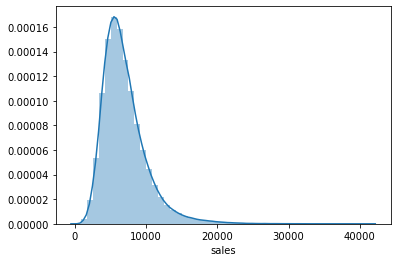

In [25]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical Variable

<ipython-input-26-d3f6ed930134>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  num_attributes.hist(bins = 25, ax = fig.gca(), grid = False);


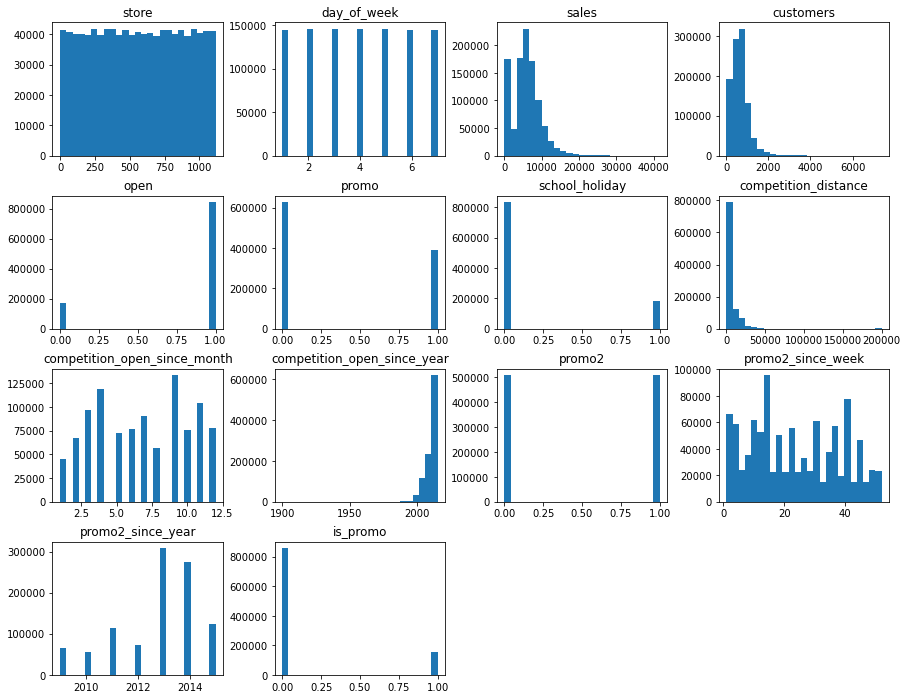

In [26]:
fig = plt.figure(figsize = (15,12))
num_attributes.hist(bins = 25, ax = fig.gca(), grid = False);

In [27]:
# create a list of the relation between each column with the sales.

### 4.1.3 Categorical Variable

<AxesSubplot:>

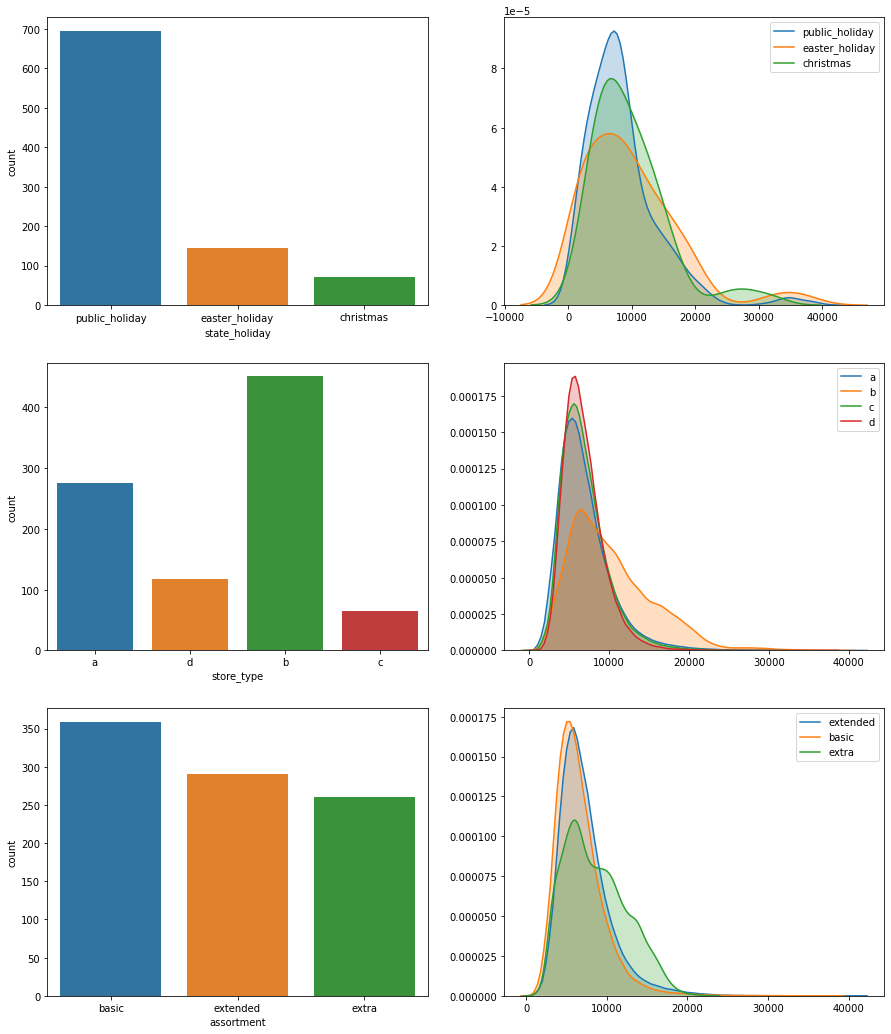

In [28]:
# satate_holiday
a = df4[df4['state_holiday'] != 'regular_day']
fig = plt.figure(figsize = (15,18))
plt.subplot (3,2,1)
sns.countplot(a['state_holiday'],  ax = fig.gca())

plt.subplot (3,2,2)
sns.kdeplot (df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot (df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot (df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)

# store_type
plt.subplot (3,2,3)
sns.countplot(a['store_type'],  ax = fig.gca())

plt.subplot (3,2,4)
sns.kdeplot (df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot (df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot (df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot (df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)

# assortment
plt.subplot (3,2,5)
sns.countplot(a['assortment'],  ax = fig.gca())

plt.subplot (3,2,6)
sns.kdeplot (df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot (df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot (df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)

## 4.2 Bivariate Analysis

### H1: Stores with more assortment should have more sales.
**TRUE.** Stores with MORE ASSORTMENT have MORE SALES.

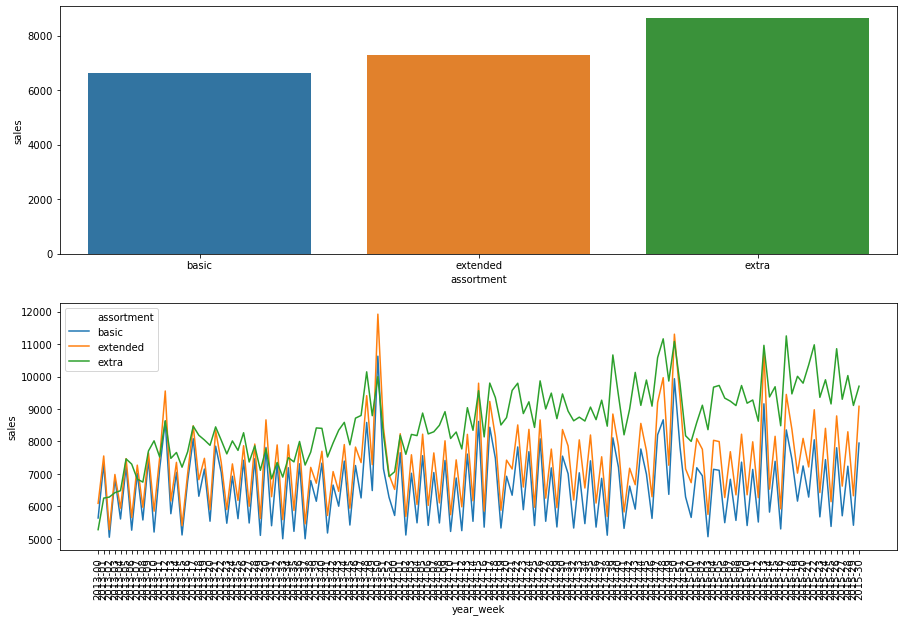

In [29]:
fig = plt.figure(figsize = (15,10))

plt.subplot (2,1,1)
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot (x = 'assortment', y = 'sales', data = aux1, ax = fig.gca())

plt.subplot (2,1,2)
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
#aux2.pivot (index = 'year_week', columns = 'assortment', values = 'sales').plot()
sns.lineplot(x='year_week', y='sales', hue='assortment', data = aux2)
plt.xticks(rotation = 90);

### H2: Stores with closer competitors should sell less.
**FALSE.** Stores with CLOSE COMPETITORS have almost igual sales.

<AxesSubplot:>

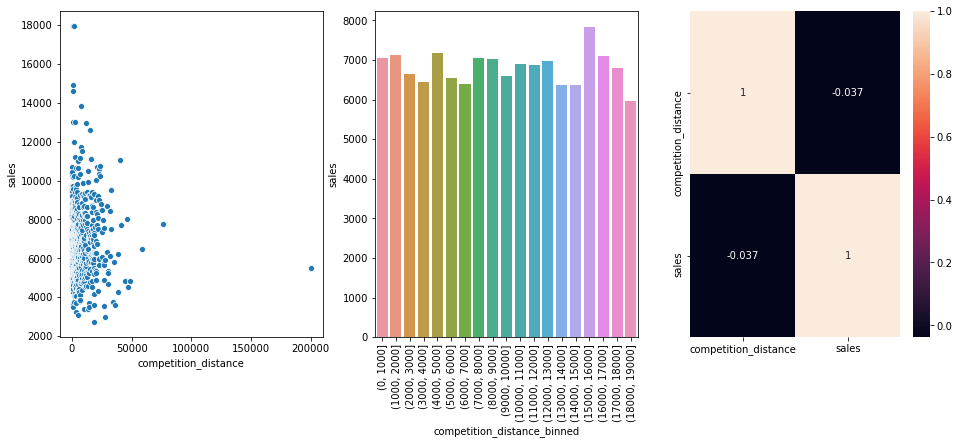

In [30]:
fig = plt.figure(figsize = (16,6))

plt.subplot (1,3,1)
aux1 = df4[['competition_distance', 'sales']].groupby ('competition_distance').mean().reset_index()
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

plt.subplot (1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut (aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby ('competition_distance_binned').mean().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2)
plt.xticks(rotation = 90);

plt.subplot (1,3,3)
sns.heatmap(aux1.corr(method= 'pearson'), annot = True)

### H3: Stores with longer competitors should sell more.
**FALSE.** Stores with LONGER COMPETITORS have LESS SALES.

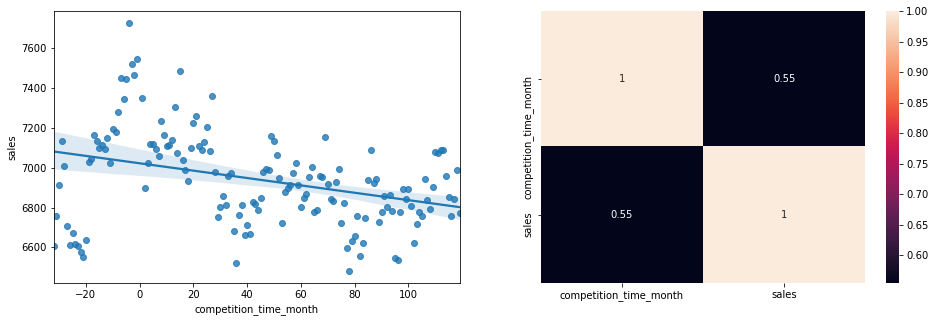

In [31]:
fig = plt.figure(figsize = (16,5))
grid = gridspec.GridSpec(1,2)

plt.subplot (grid[0,0])
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month'] != 0)]
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot (grid[0,1])
sns.heatmap( aux1.corr( method = 'pearson'), annot = True)
plt.yticks( rotation = 90);

### H4: Stores that carry out extended promotions should sell more.
**TRUE.** Stores with active promotions for longer SELL MORE.

<AxesSubplot:>

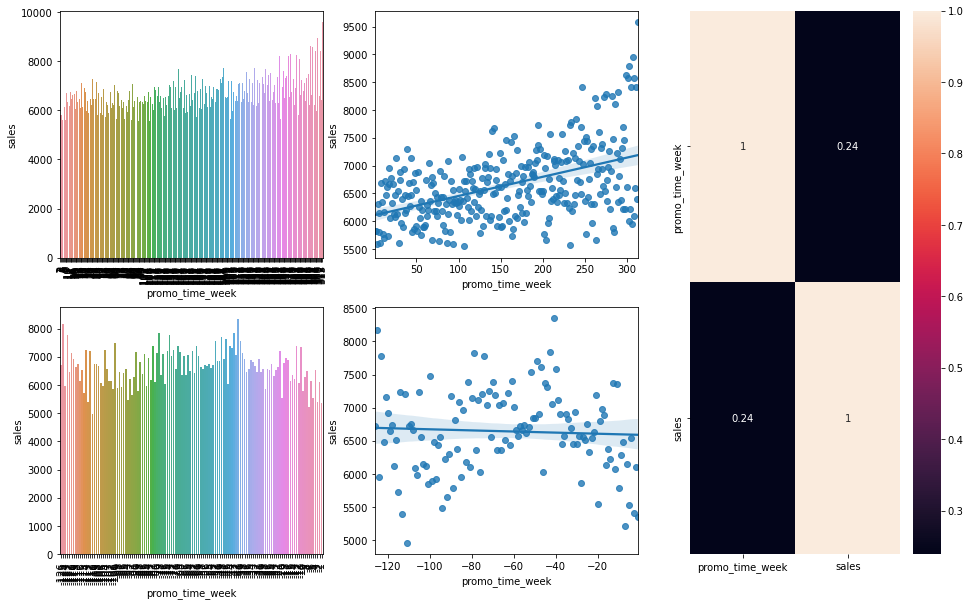

In [32]:
fig = plt.figure(figsize = (16,10))
grid = gridspec.GridSpec(2,3)

aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()

plt.subplot (grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promotions
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2)
plt.xticks( rotation = 90);

plt.subplot (grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2)

plt.subplot (grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promotions
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3)
plt.xticks( rotation = 90);

plt.subplot (grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3)

plt.subplot (grid[:,2])
sns.heatmap(aux1.corr( method = 'pearson'), annot = True)

### H5: Stores with more days of promotions should sell more.
**TRUE** Stores with MORE DAYS of promotions SELL MORE, but the proportion of sales is higher during the 'promo'.

<AxesSubplot:>

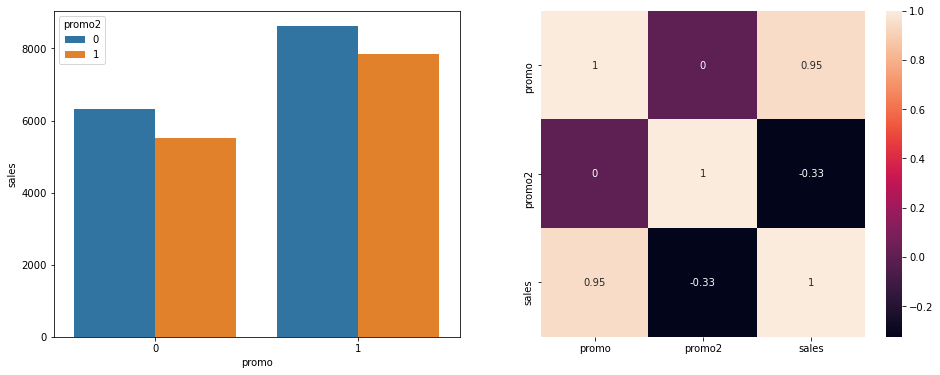

In [33]:
fig = plt.figure(figsize = (16,6))
aux1 = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index()

plt.subplot (1,2,1)
sns.barplot(x = 'promo', y = 'sales', hue = 'promo2', data = aux1);

plt.subplot (1,2,2)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True)

### H6: Stores with more consecutive promotions should sell more.
**TRUE** Stores with more consecutive promotions SELL MORE.

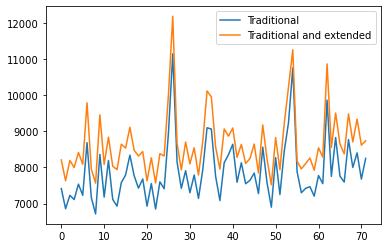

In [34]:
aux1 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 1 )][['year_week','sales']].groupby('year_week').mean().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 0 )][['year_week','sales']].groupby('year_week').mean().reset_index()
aux2.plot( ax = ax )

ax.legend( labels = ['Traditional', 'Traditional and extended']);

### H7: Stores open during the Christmas holiday should sell more.
**TRUE** Stores open during Crhistmas holiday sell more.

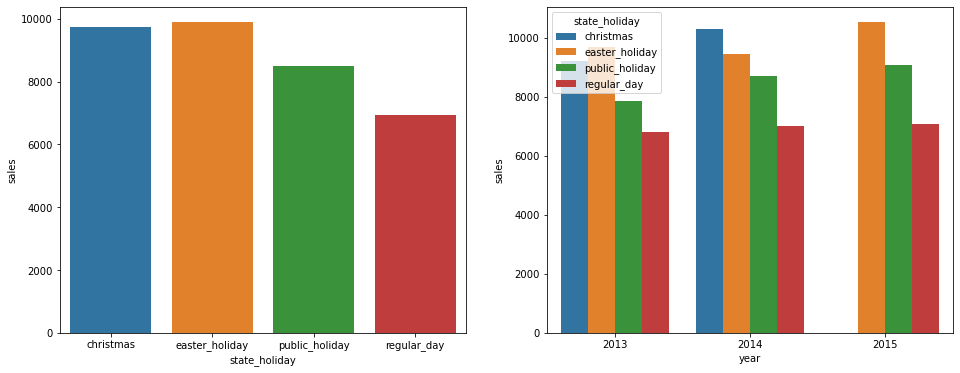

In [35]:
fig = plt.figure(figsize = (16,6))


plt.subplot(1,2,1)
aux1 = df4[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1,2,2)
aux2 = df4[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).mean().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);

### H8: Older stores should sell more.
**FALSE** Older stores sell less.

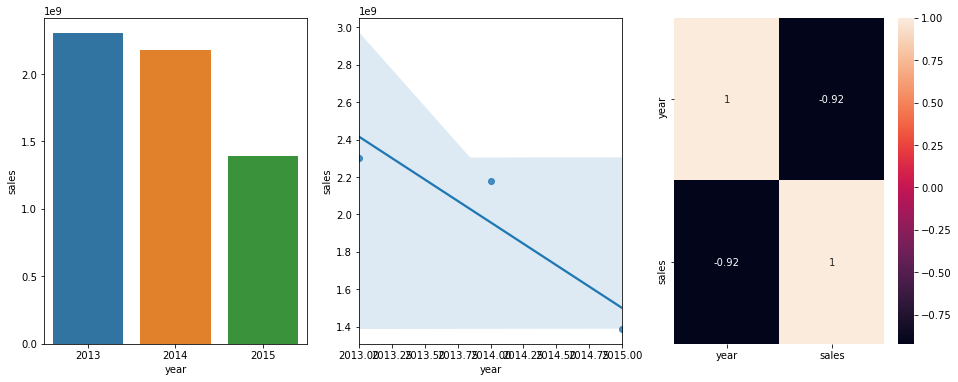

In [36]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
fig = plt.figure(figsize = (16,6))

plt.subplot(1,3,1)
sns.barplot( x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'year', y ='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H9: Stores should sell more in the second half of the year.
**True** December is the month that sells the most.

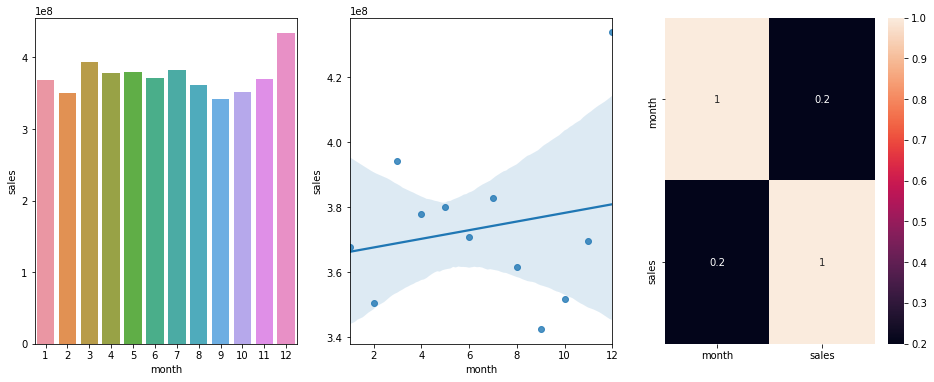

In [37]:
a = df4[df4['year'] != 2015]

aux1 = a[['month','sales']].groupby('month').sum().reset_index()
fig = plt.figure(figsize = (16,6))

plt.subplot(1,3,1)
sns.barplot( x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'month', y ='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H10: Stores should sell more before the 10th day of each month.
**FALSE** Stores don't sell more before the 10th day of each month.

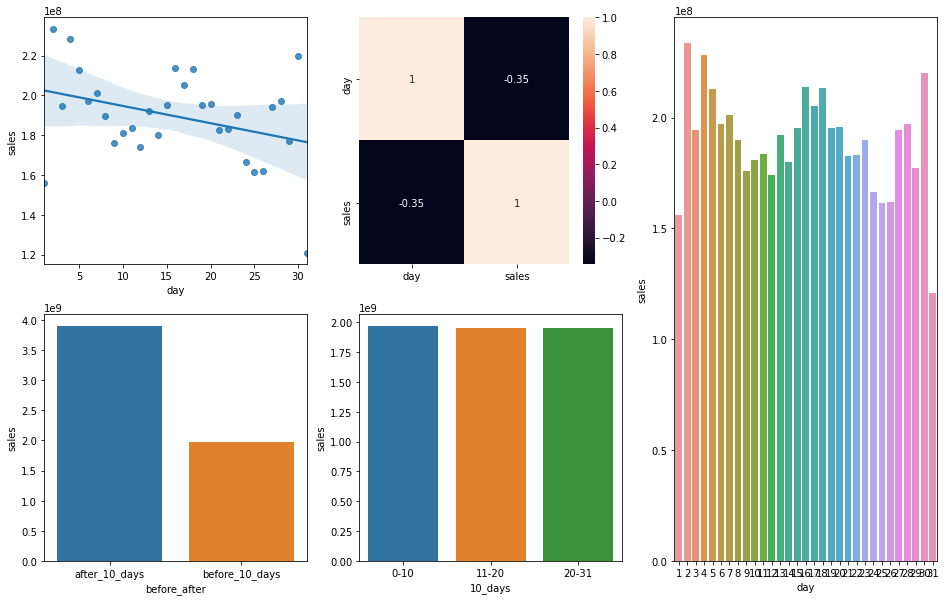

In [54]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
fig = plt.figure(figsize = (16,10))
grid = gridspec.GridSpec(2,3)

plt.subplot (grid[:,2])
sns.barplot( x = 'day', y = 'sales', data = aux1);

plt.subplot (grid[0,0])
sns.regplot(x = 'day', y ='sales', data = aux1);

plt.subplot (grid[0,1])
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

plt.subplot (grid[1,0])
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot( x = 'before_after', y = 'sales', data = aux2);

plt.subplot (grid[1,1])
aux1['10_days'] = aux1['day'].apply( lambda x: '0-10' if x <= 10 else ( '11-20' if 10<x<= 20 else '20-31'))
aux3 = aux1[['10_days','sales']].groupby('10_days').sum().reset_index()
sns.barplot( x = '10_days', y = 'sales', data = aux3);

### H11: Stores should sell less on weekends.
**True** Stores sell less on weekends.

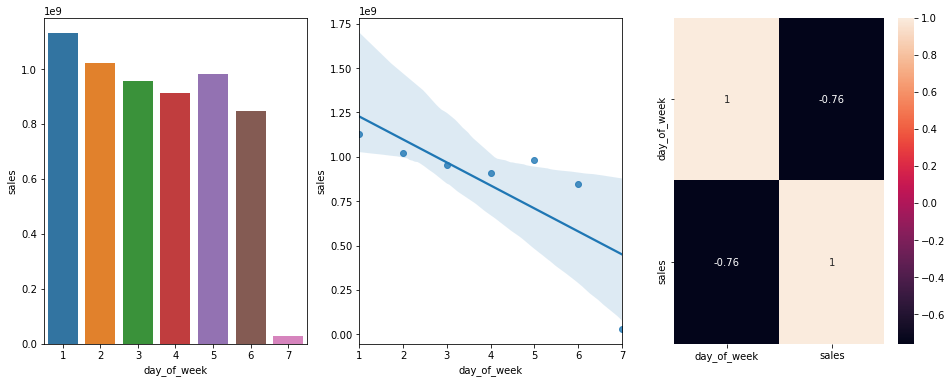

In [55]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
fig = plt.figure(figsize = (16,6))

plt.subplot(1,3,1)
sns.barplot( x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y ='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H12: Stores should sell less during school holidays.
**FALSE** Stores sells more in holidays than in ordinary days.

Text(0.5, 1.0, 'Mean Sales per day')

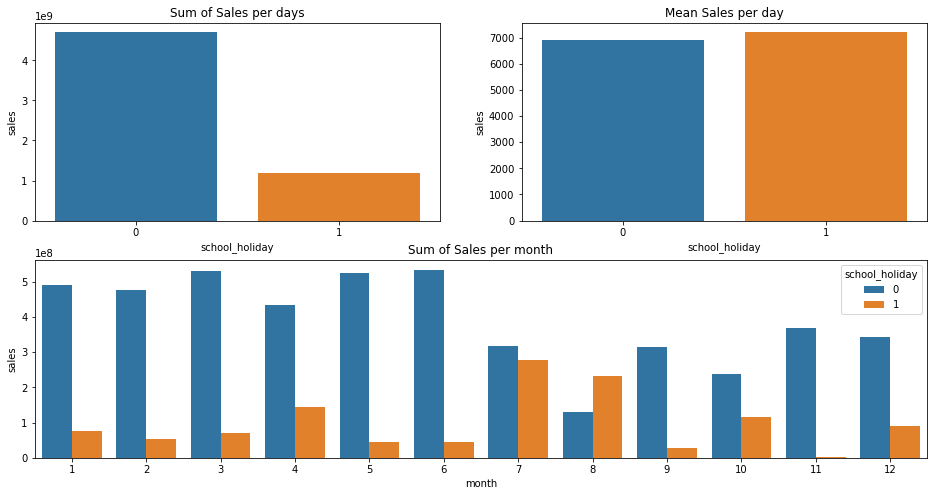

In [67]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
fig = plt.figure(figsize = (16,8))
grid = gridspec.GridSpec(2,2)

plt.subplot (grid[0,0])
sns.barplot( x = 'school_holiday', y = 'sales', data = aux1);
plt.title('Sum of Sales per days')

plt.subplot (grid[1,:])
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot( x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);
plt.title('Sum of Sales per month')

plt.subplot (grid[0,1])
aux3 = df4[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()
sns.barplot( x = 'school_holiday', y = 'sales', data = aux3);
plt.title('Mean Sales per day')

## 4.3 Multivariate Analysis